In [22]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
directorio_base = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Subir dos directorios
directorio_pkl = os.path.join(directorio_base, "src", "00.data", "clustering")

# Obtener todos los archivos .pkl en el directorio de preprocesado
archivos_pkl = [f for f in os.listdir(directorio_pkl) if f.startswith("df_clustering_") and f.endswith(".pkl")]

# Si no se encuentran archivos .pkl, mostramos un mensaje
if not archivos_pkl:
    print("❌ No se encontraron archivos .pkl en el directorio.")
else:
    df_lista = []

    # Cargar todos los archivos .pkl
    for archivo in archivos_pkl:
        ruta_archivo = os.path.join(directorio_pkl, archivo)
        try:
            with open(ruta_archivo, "rb") as f:
                df_lista.append(pickle.load(f))
                print(f"✅ Archivo cargado correctamente: {archivo}")
        except FileNotFoundError:
            print(f"❌ No se encontró el archivo: {archivo}")
        except Exception as e:
            print(f"❌ Error al cargar {archivo}: {e}")

    # Concatenar todos los DataFrames en uno solo
    if df_lista:
        df = pd.concat(df_lista, ignore_index=True)
        print(f"✅ DataFrame final con {df.shape[0]} filas y {df.shape[1]} columnas")
    else:
        print("❌ No se cargaron DataFrames.")

✅ Archivo cargado correctamente: df_clustering_1.pkl
✅ Archivo cargado correctamente: df_clustering_2.pkl
✅ Archivo cargado correctamente: df_clustering_3.pkl
✅ DataFrame final con 207137 filas y 10 columnas


In [3]:
df.head()

,news_id,meneos,clicks,karma,positive_votes,negative_votes,anonymous_votes,comments,category,cluster
0,4032594,115,651.0,410,57,1,58,30,Política y Sociedad,0
1,4032568,77,982.0,362,50,2,27,24,Entretenimiento y Cultura,0
2,4032569,97,761.0,369,50,0,47,70,Política y Sociedad,0
3,4032482,141,505.0,352,77,1,64,53,Política y Sociedad,0
4,4032509,213,335.0,349,99,1,114,28,Política y Sociedad,0


In [4]:
df_regression = df.drop(columns=['cluster', 'news_id'])
df_regression.shape

(207137, 8)

In [5]:
# df_filtered = df_regression[df_regression['clicks'] > 0].copy()
# df_filtered.shape

In [6]:
# Filtrar outliers usando Tukey
def remove_outliers_tukey(df, columns):

    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)

    IQR = Q3 - Q1

    df_no_outliers = df[~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_no_outliers

# Especificar las columnas numéricas que vamos a filtrar
num_features = ['meneos', 'karma', 'positive_votes', 'anonymous_votes', 'negative_votes', 'comments']

# Eliminar outliers en las columnas numéricas seleccionadas usando el método de Tukey
df_filtered = remove_outliers_tukey(df_regression, num_features)

# Ver cuántas filas quedaron después de eliminar outliers
print(f'Número de filas antes de eliminar outliers: {len(df_regression)}')
print(f'Número de filas después de eliminar outliers: {len(df_filtered)}')

Número de filas antes de eliminar outliers: 207137
Número de filas después de eliminar outliers: 169077


In [7]:
df_filtered['clicks'] = np.log1p(df_filtered['clicks'])

C:\Users\Jordi\AppData\Local\Temp\ipykernel_456\496003369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['clicks'] = np.log1p(df_filtered['clicks'])


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Convertir a float32 antes de escalar
df_filtered[num_features] = df_filtered[num_features].astype('float32')

# Aplicar MinMaxScaler
regressor_scaler = MinMaxScaler()
df_filtered[num_features] = regressor_scaler.fit_transform(df_filtered[num_features])

C:\Users\Jordi\AppData\Local\Temp\ipykernel_456\3181967071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[num_features] = df_filtered[num_features].astype('float32')
C:\Users\Jordi\AppData\Local\Temp\ipykernel_456\3181967071.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[num_features] = regressor_scaler.fit_transform(df_filtered[num_features])


In [9]:
# Guardar el escalador
regressor_scaler_path = "../00.data/clustering/regressor_scaler.pkl"

with open(regressor_scaler_path, "wb") as f:
    pickle.dump(regressor_scaler, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
from sklearn.preprocessing import OneHotEncoder

# Aplicar OneHotEncoder a la categoría
regressor_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = regressor_encoder.fit_transform(df_filtered[['category']])

In [11]:
# Guardar el encoder
regressor_encoder_path = "../00.data/clustering/regressor_encoder.pkl"

with open(regressor_encoder_path, "wb") as f:
    pickle.dump(regressor_encoder, f, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# Convertir a DataFrame
encoded_df = pd.DataFrame(encoded_cats, columns=regressor_encoder.get_feature_names_out(['category']))

# Resetear índices
df_filtered = df_filtered.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Unir con el dataset original
df_final = pd.concat([df_filtered, encoded_df], axis=1)

# Eliminar la columna categórica original
df_final.drop(columns=['category'], inplace=True)

In [13]:
from sklearn.model_selection import train_test_split

# Definir X (features) e y (target)
X = df_final.drop(columns=['clicks'])
y = df_final['clicks']

X = X.astype('float32')

# Dividir en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_log_error, r2_score, explained_variance_score

# Entrenar modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred = model.predict(X_test)

# Invertir la transformación logarítmica
y_pred = np.expm1(np.maximum(y_pred, 0))
y_test = np.expm1(y_test)

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
var = explained_variance_score(y_test, y_pred)

# Imprimir las métricas
print(f'Median AE: {medae:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MSLE: {msle:.4f}')
print(f'R2: {r2:.2f}')
print(f'Explained Variance: {var:.2f}')

Median AE: 1454.97
MAE: 2569.15
MSLE: 0.6114
R2: 0.15
Explained Variance: 0.22


### Evaluar la Correlación de Features con clicks

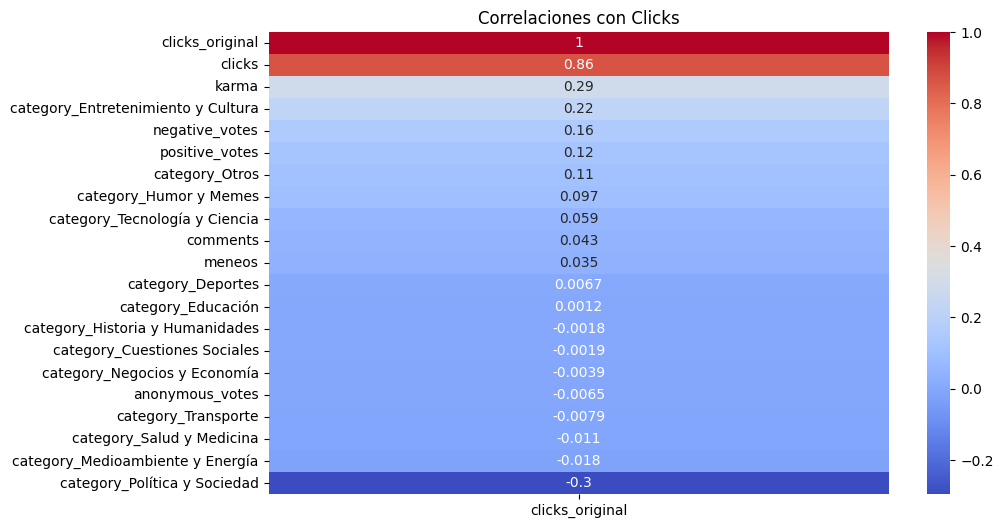

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir clicks a escala original para evaluar correlaciones
df_final['clicks_original'] = np.expm1(df_final['clicks'])

# Calcular la matriz de correlación
correlation_matrix = df_final.corr()

# Mostrar correlaciones con 'clicks_original'
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix[['clicks_original']].sort_values(by='clicks_original', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlaciones con Clicks')
plt.show()

### Probar con otros modelos: Random Forest Regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_log_error, r2_score, explained_variance_score

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = np.expm1(rf_model.predict(X_test))  # Deshacer transformación logarítmica
mae_rf = mean_absolute_error(y_test, y_pred_rf)
medae_rf = median_absolute_error(y_test, y_pred_rf)
msle_rf = mean_squared_log_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
var_rf = explained_variance_score(y_test, y_pred_rf)

print(f'Random Forest Median AE: {medae_rf:.2f}')
print(f'Random Forest MAE: {mae_rf:.2f}')
print(f'Random Forest MSLE: {msle_rf:.4f}')
print(f'Random Forest R2: {r2_rf:.2f}')
print(f'Random Forest Explained Variance: {var_rf:.2f}')

Random Forest Median AE: 1375.74
Random Forest MAE: 2446.04
Random Forest MSLE: 0.5736
Random Forest R2: 0.24
Random Forest Explained Variance: 0.29


In [17]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=20, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = np.expm1(gb_model.predict(X_test))  # Deshacer transformación logarítmica
mae_gb = mean_absolute_error(y_test, y_pred_gb)
medae_gb = median_absolute_error(y_test, y_pred_gb)
msle_gb = mean_squared_log_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
var_gb = explained_variance_score(y_test, y_pred_gb)

print(f'Gradient Boosting Median AE: {medae_gb:.2f}')
print(f'Gradient Boosting MAE: {mae_gb:.2f}')
print(f'Gradient Boosting MSLE: {msle_gb:.4f}')
print(f'Gradient Boosting R2: {r2_gb:.2f}')
print(f'Gradient Boosting Explained Variance: {var_gb:.2f}')

Gradient Boosting Median AE: 1511.70
Gradient Boosting MAE: 2614.74
Gradient Boosting MSLE: 0.6704
Gradient Boosting R2: 0.17
Gradient Boosting Explained Variance: 0.20


In [18]:
# Crear un diccionario con los resultados de los modelos
results = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MAE': [mae, mae_rf, mae_gb],
    'Median AE': [medae, medae_rf, medae_gb],
    'MSLE': [msle, msle_rf, msle_gb],
    'R2': [r2, r2_rf, r2_gb],
    'Explained Variance': [var, var_rf, var_gb]
}

results_df = pd.DataFrame(results)

In [19]:
results_df

,Model,MAE,Median AE,MSLE,R2,Explained Variance
0,Linear Regression,2569.147949,1454.972168,0.611352,0.150689,0.218874
1,Random Forest,2446.039821,1375.742401,0.573580,0.236160,0.286096
2,Gradient Boosting,2614.735907,1511.700103,0.670375,0.167590,0.201666


In [21]:
# Guardar el modelo
ml_regression_path = "../00.data/clustering/ml_regression.pkl"

with open(ml_regression_path, "wb") as f:
    pickle.dump(rf_model, f, protocol=pickle.HIGHEST_PROTOCOL)

### Feature Engineering

%%time

from sklearn.model_selection import GridSearchCV

# Definir el modelo Random Forest
model = RandomForestRegressor(random_state=42)

# Definir los parámetros para GridSearchCV
params = {
    "n_estimators": [100, 150],
    "criterion": ["squared_error", "absolute_error"],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [5, 10],
    "random_state": [42]
}

# Definir el GridSearchCV
scorers = {
    "MAE": "neg_mean_absolute_error",
    "MedAE": "neg_median_absolute_error",
    "MSLE": "neg_mean_squared_log_error",
    "R2": "r2",
    "EVS": "explained_variance"
}

grid_solver = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring=scorers,
    cv=5,
    refit="MAE",
    n_jobs=-1,
    verbose=3
)

# Ajustar el modelo
model_result = grid_solver.fit(X_train, y_train)

# Mostrar métricas promedio
print("Mean Test Median Absolute Error:", model_result.cv_results_["mean_test_MedAE"].mean())
print("Mean Test Mean Squared Log Error:", model_result.cv_results_["mean_test_MSLE"].mean())
print("Mean Test R2 Score:", model_result.cv_results_["mean_test_R2"].mean())
print("Mean Test Explained Variance Score:", model_result.cv_results_["mean_test_EVS"].mean())

print("*"*100)

# Mostrar los mejores parámetros
print("Mejor Score (MAE):", model_result.best_score_)
print("Mejores Parámetros:", model_result.best_params_)

# Evaluación con los mejores parámetros
best_rf_model = model_result.best_estimator_
y_pred_rf_best = np.expm1(best_rf_model.predict(X_test))  # Deshacer transformación logarítmica

# Calcular métricas con el mejor modelo
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
medae_rf_best = median_absolute_error(y_test, y_pred_rf_best)
msle_rf_best = mean_squared_log_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)
ev_rf_best = explained_variance_score(y_test, y_pred_rf_best)

print(f'Random Forest con GridSearch MAE: {mae_rf_best:.2f}')
print(f'Random Forest con GridSearch MedAE: {medae_rf_best:.2f}')
print(f'Random Forest con GridSearch MSLE: {msle_rf_best:.4f}')
print(f'Random Forest con GridSearch R2 Score: {r2_rf_best:.4f}')
print(f'Random Forest con GridSearch Explained Variance Score: {ev_rf_best:.4f}')